<a href="https://colab.research.google.com/github/realBagher/Document_Classification/blob/main/bert_uncased/Document_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle.

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d shivamkushwaha/bbc-full-text-document-classification

  0% 0.00/5.59M [00:00<?, ?B/s]
100% 5.59M/5.59M [00:00<00:00, 67.2MB/s]


In [7]:
!unzip -q "/content/bbc-full-text-document-classification.zip"


In [8]:

import numpy as np 
import pandas as pd
import os  
import glob
import io
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import seaborn as sns

In [9]:
dir_path = []
for dirname, _, filenames in os.walk('/content/bbc-fulltext (document classification)/bbc'):
    dir_path.append(dirname)

dir_path

['/content/bbc-fulltext (document classification)/bbc',
 '/content/bbc-fulltext (document classification)/bbc/sport',
 '/content/bbc-fulltext (document classification)/bbc/tech',
 '/content/bbc-fulltext (document classification)/bbc/entertainment',
 '/content/bbc-fulltext (document classification)/bbc/business',
 '/content/bbc-fulltext (document classification)/bbc/politics']

In [10]:

def text_to_df(path):
    df = pd.DataFrame(columns=['news', 'class'])
    txt = []
    label = []
    
    for dirpath in path:
        text_files_path = sorted(glob.glob(os.path.join(dirpath, '*.txt')))
        
        for text_path in text_files_path:
            with io.open(text_path, 'r', encoding='utf-8', errors='ignore') as txt_file:
                txt.append(txt_file.read())
                label.append(dirpath.split('/')[-1])

    df['news'] = txt
    df['class'] = label
    txt, label = [], []
    
    return df

In [11]:
df = text_to_df(dir_path[1:])
df

,news,class
0,Claxton hunting first major medal\n\nBritish h...,sport
1,O'Sullivan could run in Worlds\n\nSonia O'Sull...,sport
2,Greene sets sights on world title\n\nMaurice G...,sport
3,IAAF launches fight against drugs\n\nThe IAAF ...,sport
4,"Dibaba breaks 5,000m world record\n\nEthiopia'...",sport
...,...,...
2220,Sainsbury's Labour election gift\n\nScience Mi...,politics
2221,Blair 'up for it' ahead of poll\n\nTony Blair ...,politics
2222,Labour MP praises Tory campaign\n\nThe Conserv...,politics
2223,Top Tories on Lib Dem 'hit list'\n\nThe Libera...,politics


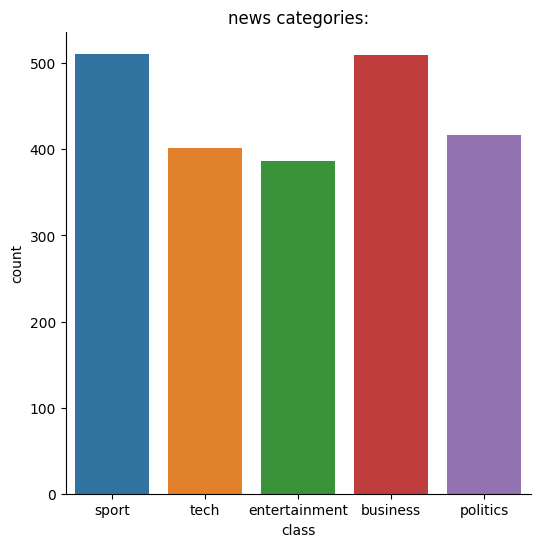

In [12]:
plt.figure(figsize=(6,6))
plt.title("news categories:")
sns.countplot(x=df["class"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [14]:

X = df['news']

#label one_hot encoding
y = np.array(df['class'])
y = np.reshape(y, (-1,1))
y = OneHotEncoder().fit_transform(y).toarray()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train

1490    Borussia Dortmund near bust\n\nGerman football...
2001    Cherie accused of attacking Bush\n\nCherie Bla...
1572    Five million Germans out of work\n\nGermany's ...
1840    Protesters plan airport challenge\n\nCampaigne...
610     Honour for UK games maker\n\nLeading British c...
                              ...                        
1638    Jarvis sells Tube stake to Spain\n\nShares in ...
1095    Top of the Pops leaves BBC One\n\nThe BBC's fl...
1130    US TV host Clark suffers stroke\n\nVeteran US ...
1294    French honour for director Parker\n\nBritish f...
860     Chip maker backs net phone calls\n\nRich Templ...
Name: news, Length: 1780, dtype: object

In [ ]:
!pip install tensorflow_text

In [27]:
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score


In [19]:
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
model_preprocessing_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

preprocessor = hub.KerasLayer(model_preprocessing_url)
encoder = hub.KerasLayer(model_url)

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model

#BERT Layers
input_layer = Input(shape=(), dtype=tf.string)
preprocess_layer = preprocessor(input_layer)
bert_output = encoder(preprocess_layer)

#Fully connected layers
z = Dropout(0.1)(bert_output['pooled_output'])
z = Dense(5, activation='softmax')(z)

model = Model(inputs=input_layer, outputs=z)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', 'roc_auc', 'f1'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['input_2[0][0]']                
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [29]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.12.0
/device:GPU:0


In [24]:
model_history = model.fit(x=X_train,
                          y=y_train,
                          batch_size=32,
                          validation_split=0.2, 
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)],
                          epochs=10)

Epoch 1/10
45/45 [==============================] - 22s 480ms/step - loss: 1.6125 - accuracy: 0.2928 - val_loss: 1.3771 - val_accuracy: 0.4298
Epoch 2/10
45/45 [==============================] - 21s 468ms/step - loss: 1.3374 - accuracy: 0.4663 - val_loss: 1.1900 - val_accuracy: 0.6601
Epoch 3/10
45/45 [==============================] - 20s 447ms/step - loss: 1.1891 - accuracy: 0.5751 - val_loss: 1.0598 - val_accuracy: 0.6657
Epoch 4/10
45/45 [==============================] - 21s 468ms/step - loss: 1.0907 - accuracy: 0.6236 - val_loss: 0.9585 - val_accuracy: 0.6966
Epoch 5/10
45/45 [==============================] - 21s 467ms/step - loss: 0.9937 - accuracy: 0.6728 - val_loss: 0.8582 - val_accuracy: 0.8118
Epoch 6/10
45/45 [==============================] - 20s 440ms/step - loss: 0.9313 - accuracy: 0.6917 - val_loss: 0.8262 - val_accuracy: 0.8202
Epoch 7/10
45/45 [==============================] - 22s 500ms/step - loss: 0.8606 - accuracy: 0.7472 - val_loss: 0.7330 - val_accuracy: 0.8455

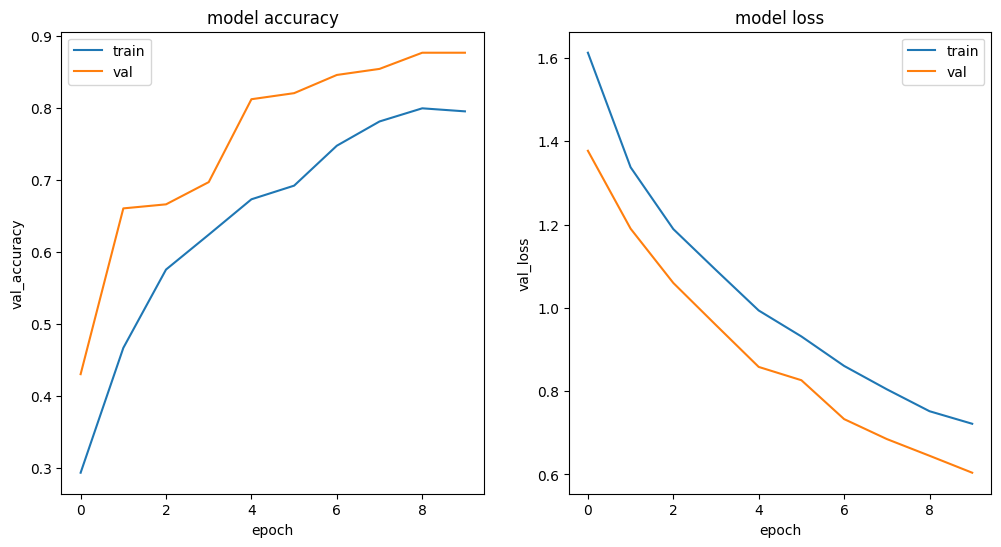

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax[0].plot(model_history.history['accuracy'])
ax[0].plot(model_history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('val_accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(model_history.history['loss'])
ax[1].plot(model_history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('val_loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper right')

fig.show()

14/14 [==============================] - 6s 400ms/step


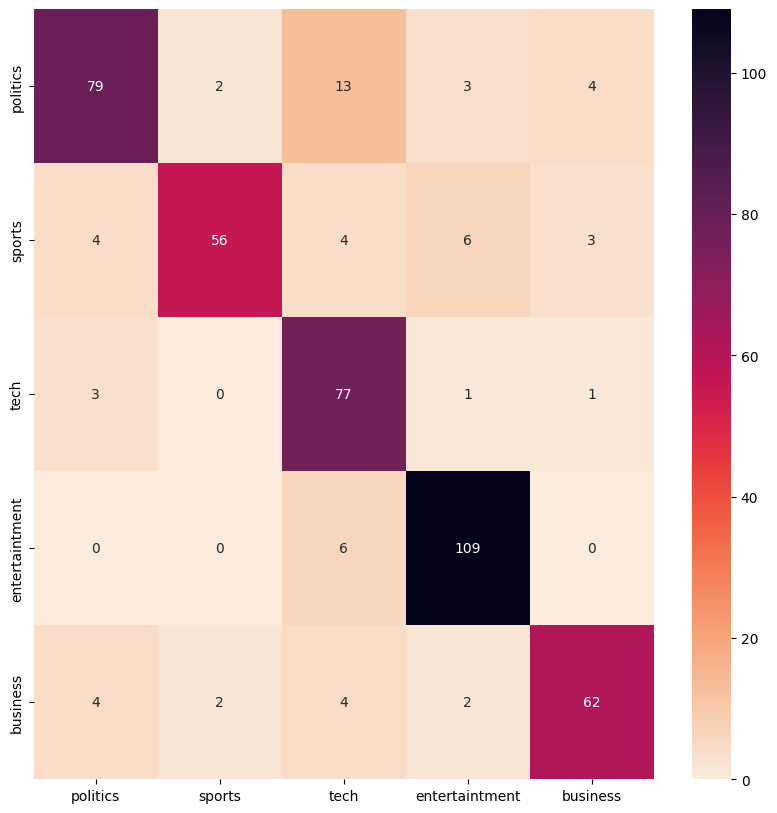

In [26]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plt.figure(figsize=(10,10))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['politics', 'sports', 'tech', 'entertaintment', 'business'], yticklabels = ['politics', 'sports', 'tech', 'entertaintment', 'business'])